In [162]:
import pandas as pd

train_h = pd.read_csv("data/train_h_final.csv")
train_no_ads = pd.read_csv("data/train_no_ads_final.csv")

## Basic Data Cleaning

Remove columns with missing values or all zeros.

Remove rows with empty structures.

In [163]:
print(f"columns in h-ads dataset before: {train_h.shape[1]}")
print(f"columns in no-ads dataset before: {train_no_ads.shape[1]}")
print(f"rows in h-ads dataset before: {train_h.shape[0]}")
print(f"rows in no-ads dataset before: {train_no_ads.shape[0]}")

# get features with all NaN values
h_nan_cols = train_h.columns[train_h.isna().all()].tolist()
no_ads_nan_cols = train_no_ads.columns[train_no_ads.isna().all()].tolist()

# get features with all 0 values
h_numeric_cols = train_h.select_dtypes(include='number')
h_zero_cols = h_numeric_cols.columns[h_numeric_cols.eq(0).all()]

no_ads_num_cols = train_no_ads.select_dtypes(include='number')
no_ads_zero_cols = no_ads_num_cols.columns[no_ads_num_cols.eq(0).all()]

print("----")
print("Columns with all missing values in h-ads dataset:", h_nan_cols)
print("Columns with all missing values in no-ads dataset:", no_ads_nan_cols)
print("0-value columns in h-ads dataset:", h_zero_cols)
print("0-value columns in no-ads dataset:", no_ads_zero_cols)

# drop bad columns and rows
train_h = train_h.drop(columns=h_nan_cols).drop(columns=h_zero_cols).dropna(subset=['structure']).reset_index(drop=True)
train_no_ads = train_no_ads.drop(columns=no_ads_nan_cols).drop(columns=no_ads_zero_cols).dropna(subset=['structure']).reset_index(drop=True)

print("----")
print(f"columns in h-ads dataset after cleaning: {train_h.shape[1]}")
print(f"columns in no-ads dataset after cleaning: {train_no_ads.shape[1]}")

print(f"rows in h-ads dataset after cleaning: {train_h.shape[0]}")
print(f"rows in no-ads dataset after cleaning: {train_no_ads.shape[0]}")

columns in h-ads dataset before: 488
columns in no-ads dataset before: 488
rows in h-ads dataset before: 1605
rows in no-ads dataset before: 14646
----
Columns with all missing values in h-ads dataset: []
Columns with all missing values in no-ads dataset: []
0-value columns in h-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData mode NfUnfilled',
       'MagpieData minimum GSbandgap', 'MagpieData mode GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
0-value columns in no-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
----
columns in h-ads dataset after cleaning: 479
co

## Step-by-Step Correlation Analysis

It is necessary to perform correlation analysis on each group of features, because we have so many total features.

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# define some helper functions to compute corr matrix and highly correlated pairs
def get_corr_mat(df, show_high_corr_pairs=False, threshold=0.9):
    corr_mat = df.corr().abs()
    upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool)) 
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(upper_tri, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True)
    plt.show()

    if show_high_corr_pairs:
        high_corr_pairs = []
        for column in upper_tri.columns:
            for row in upper_tri.index:
                if abs(upper_tri.loc[row, column]) > threshold:
                    high_corr_pairs.append((row, column, upper_tri.loc[row, column]))

        # Convert the list of pairs to a DataFrame for better readability
        high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

        # Sort by absolute correlation value for better inspection
        high_corr_df = high_corr_df.sort_values(by="Correlation", key=abs, ascending=False)

        return high_corr_df

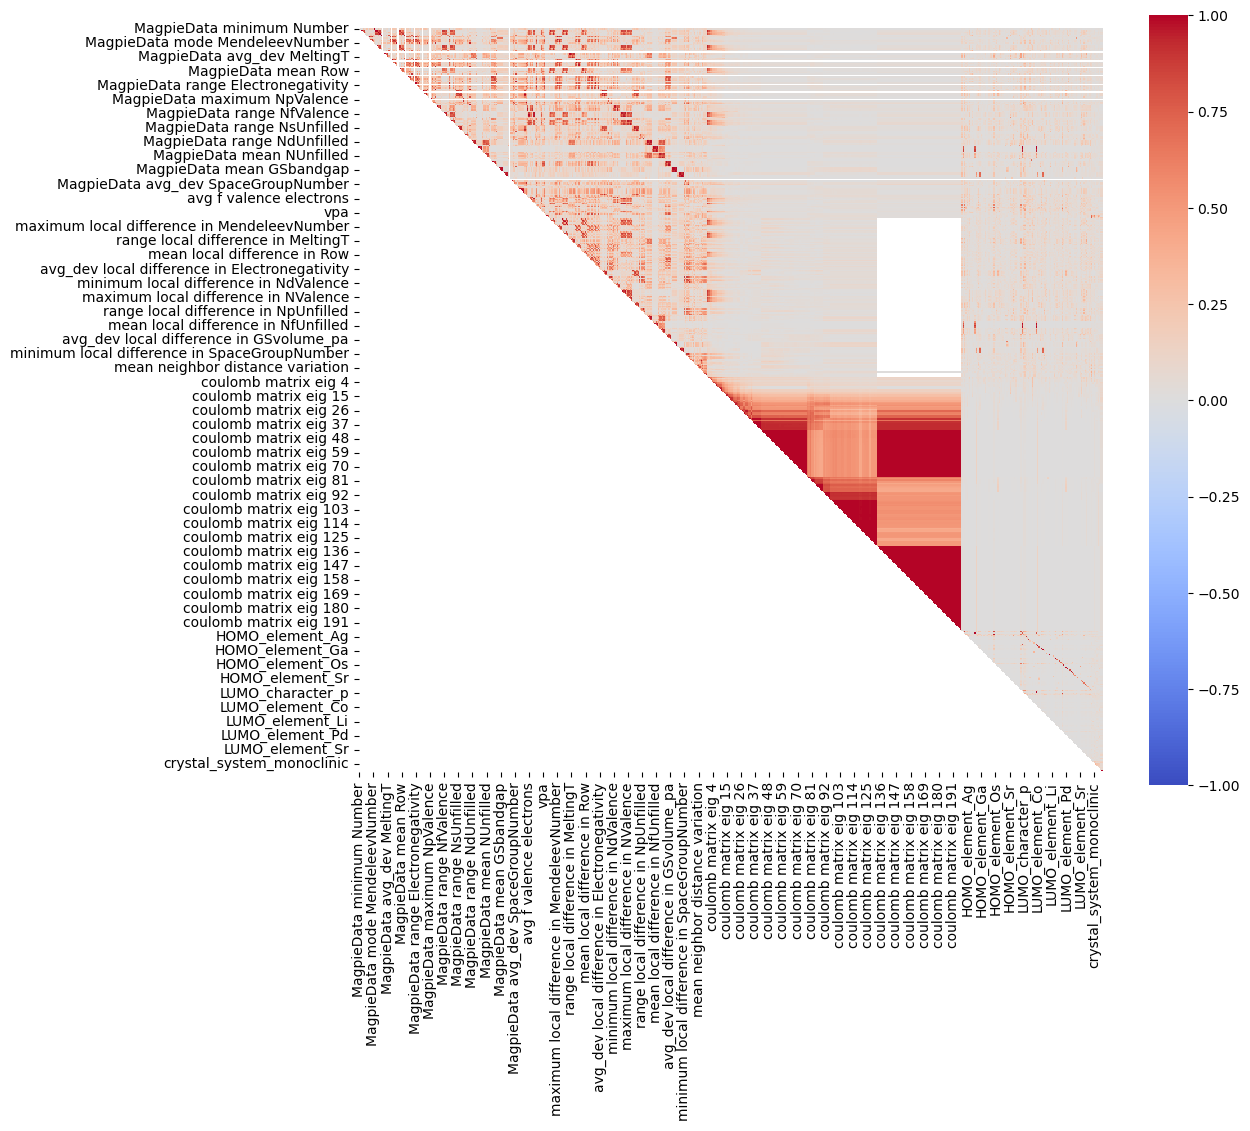

In [165]:
# drop non-numeric columns
train_h_X = train_h.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])

# hot-encode categorical features
encoded_train_h_X = pd.get_dummies(train_h_X)

get_corr_mat(encoded_train_h_X)

## Check Coloum Matrix Features

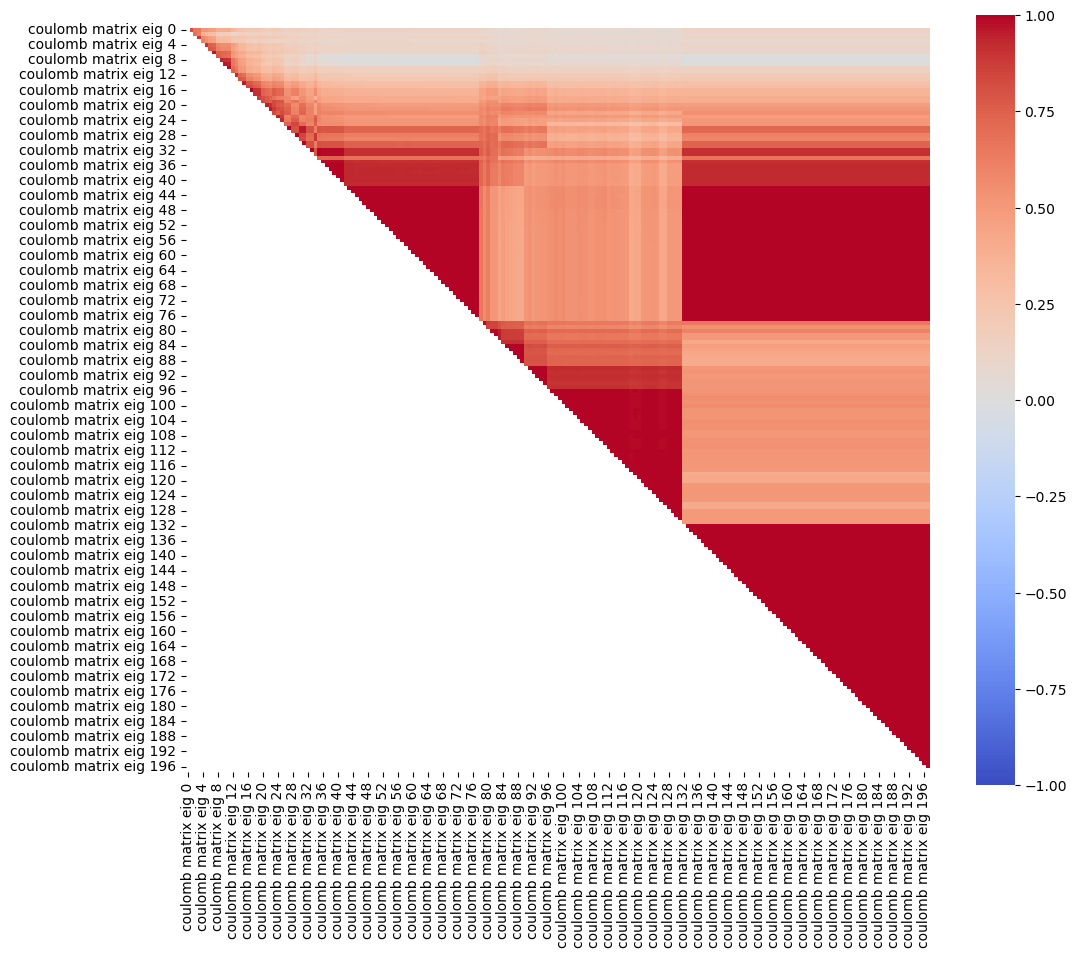

In [166]:
cm_cols = [c for c in train_h.columns if "coulomb matrix eig" in c]
get_corr_mat(train_h[cm_cols])

This looks insane.

In [167]:
# drop all coulomb matrix features
# maybe keep some?
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in train_h.columns if "coulomb matrix eig" in c]).reset_index(drop=True)

## Check HOMO/LUMO Features

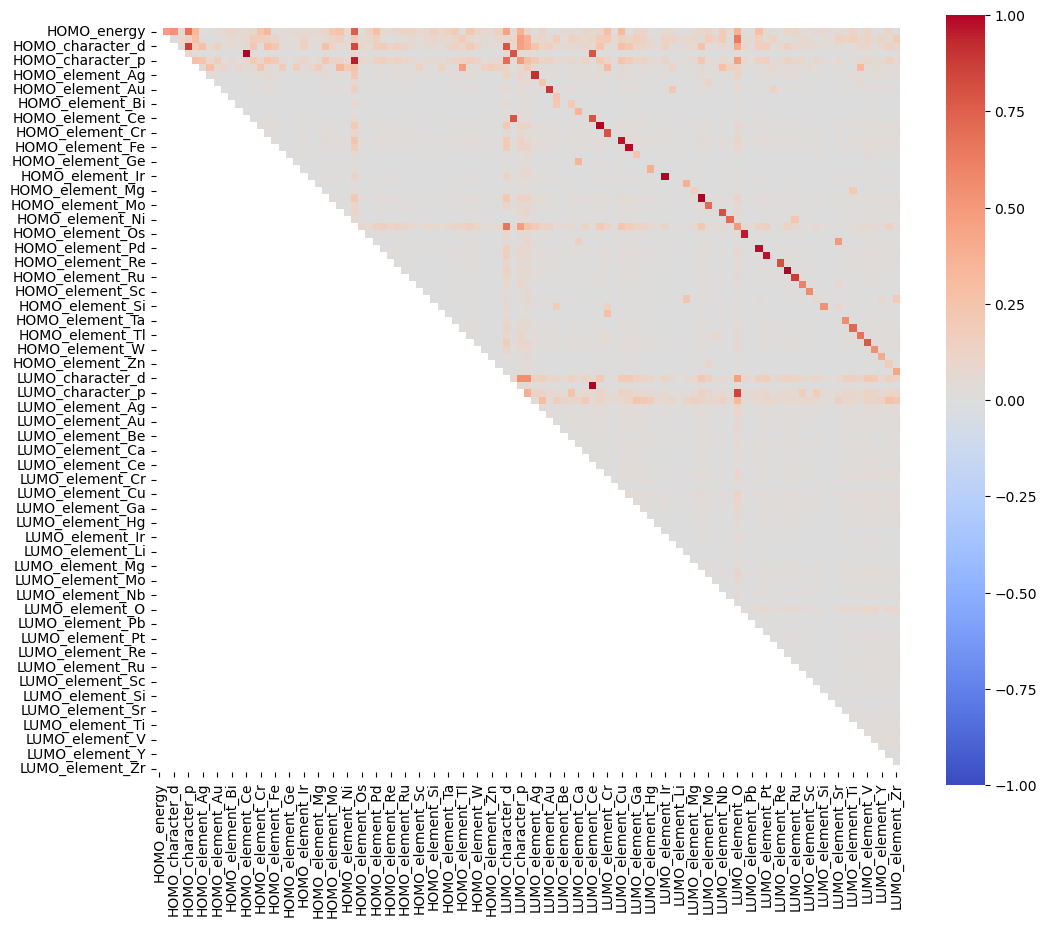

In [168]:
# compute corr matrix
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "LUMO" in c or "HOMO" in c]])

HOMO and LUMO columns are almost identical, drop one set

In [169]:
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "HOMO" in c]).reset_index(drop=True)

## Check MagpieData features

MagpieData gives:
- mode
- mean
- max 
- min
- range
- std dev
- mean local difference
- max local difference
- min local difference
- range local difference
- mean local difference
- avg dev local difference

Check each of these separately and remove highly-correlated pairs

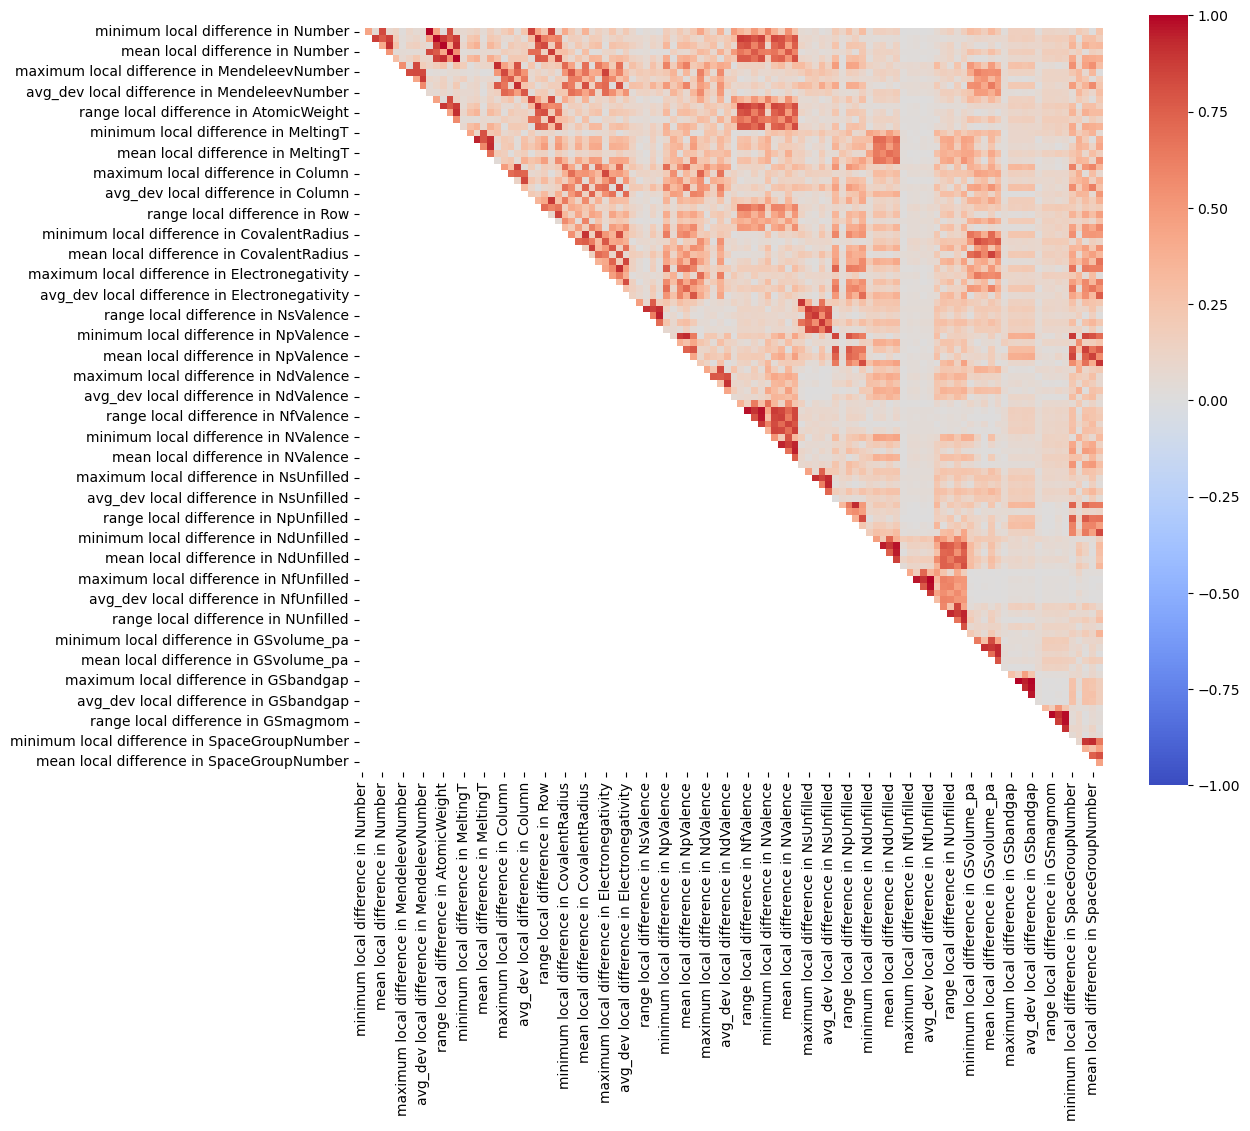

,Feature 1,Feature 2,Correlation
2,maximum local difference in Number,maximum local difference in AtomicWeight,0.999198
5,mean local difference in Number,mean local difference in AtomicWeight,0.998826
3,range local difference in Number,range local difference in AtomicWeight,0.998089
7,avg_dev local difference in Number,avg_dev local difference in AtomicWeight,0.997936
1,minimum local difference in Number,minimum local difference in AtomicWeight,0.997292
45,maximum local difference in GSbandgap,range local difference in GSbandgap,0.993852
37,maximum local difference in NfUnfilled,avg_dev local difference in NfUnfilled,0.993240
48,maximum local difference in GSbandgap,avg_dev local difference in GSbandgap,0.992982
51,maximum local difference in GSmagmom,range local difference in GSmagmom,0.989192
49,range local difference in GSbandgap,avg_dev local difference in GSbandgap,0.988911


In [170]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "difference" in c]], True)

In [171]:
# drop all local difference features
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "local difference" in c]).reset_index(drop=True)

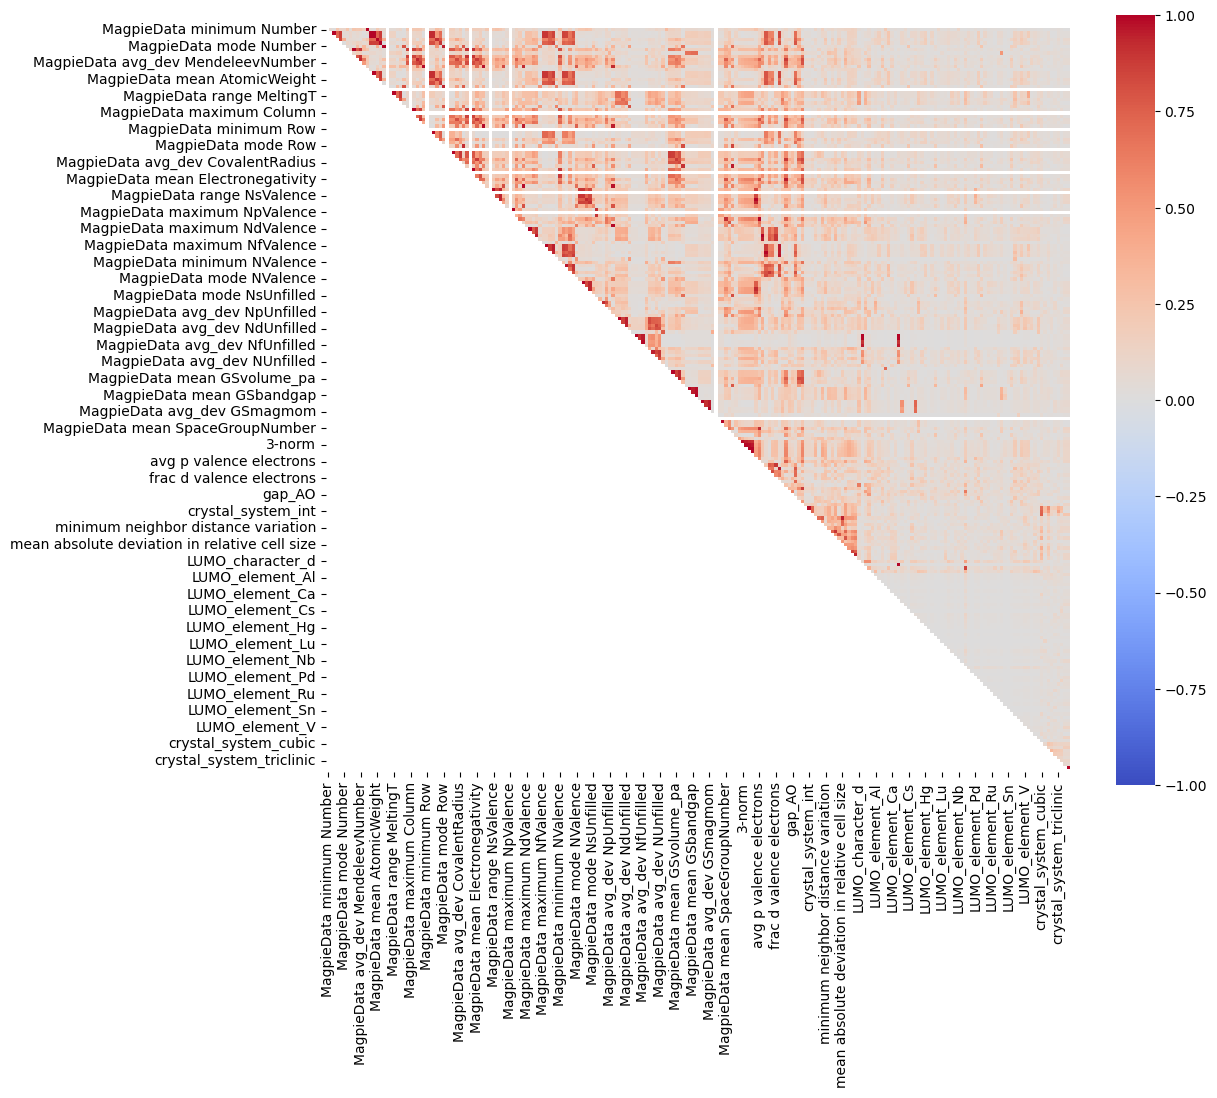

In [172]:
get_corr_mat(encoded_train_h_X)

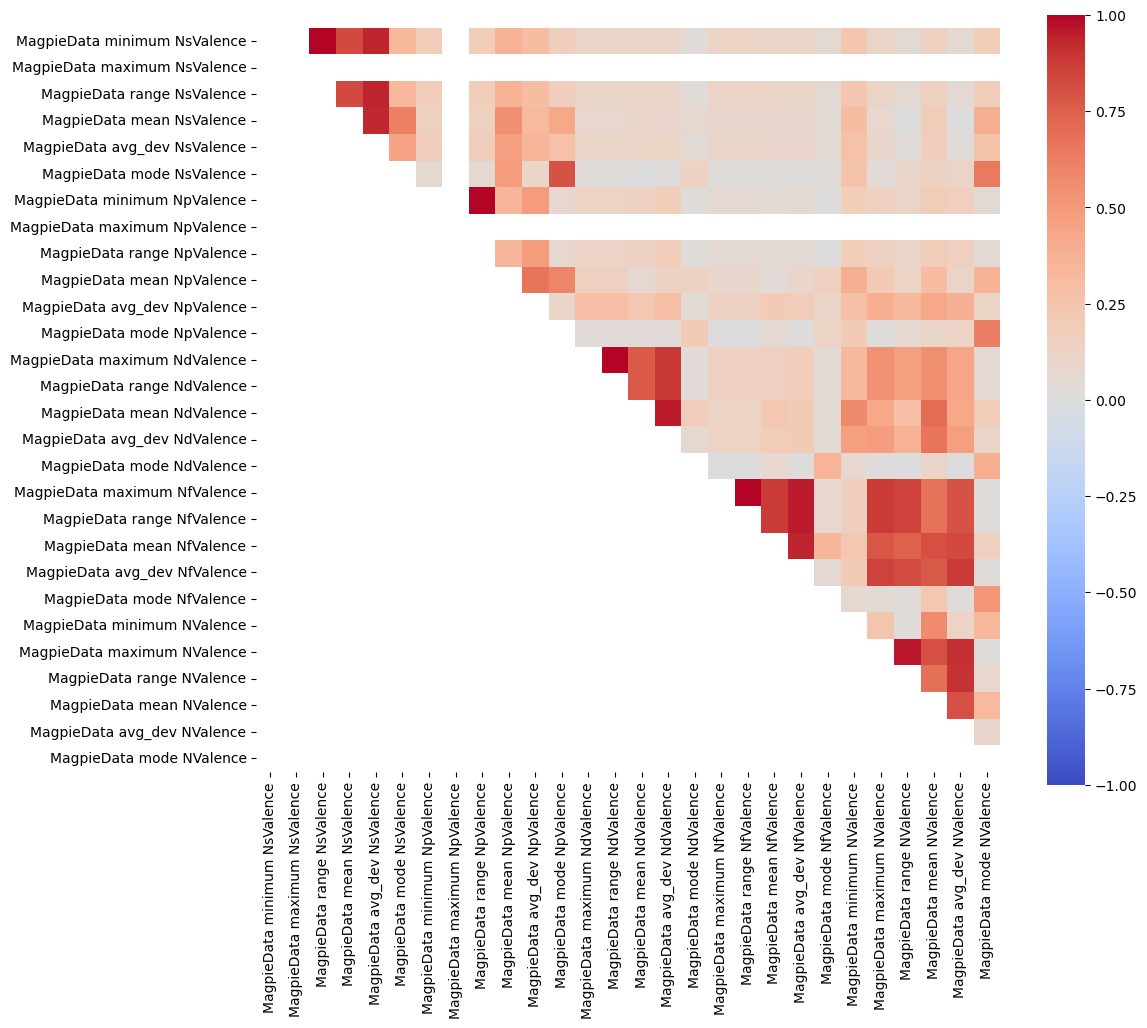

,Feature 1,Feature 2,Correlation
11,MagpieData maximum NfValence,MagpieData range NfValence,1.000000
7,MagpieData maximum NdValence,MagpieData range NdValence,1.000000
0,MagpieData minimum NsValence,MagpieData range NsValence,1.000000
6,MagpieData minimum NpValence,MagpieData range NpValence,1.000000
23,MagpieData maximum NValence,MagpieData range NValence,0.965884
14,MagpieData maximum NfValence,MagpieData avg_dev NfValence,0.955435
15,MagpieData range NfValence,MagpieData avg_dev NfValence,0.955435
10,MagpieData mean NdValence,MagpieData avg_dev NdValence,0.954282
16,MagpieData mean NfValence,MagpieData avg_dev NfValence,0.943474
3,MagpieData minimum NsValence,MagpieData avg_dev NsValence,0.937655


In [173]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "Valence" in c]], True, 0.8)

In [174]:
# drop min/max valence features
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "minimum" in c or "maximum" in c or "avg_dev" in c or "range" in c or "valence electrons" in c]).reset_index(drop=True)

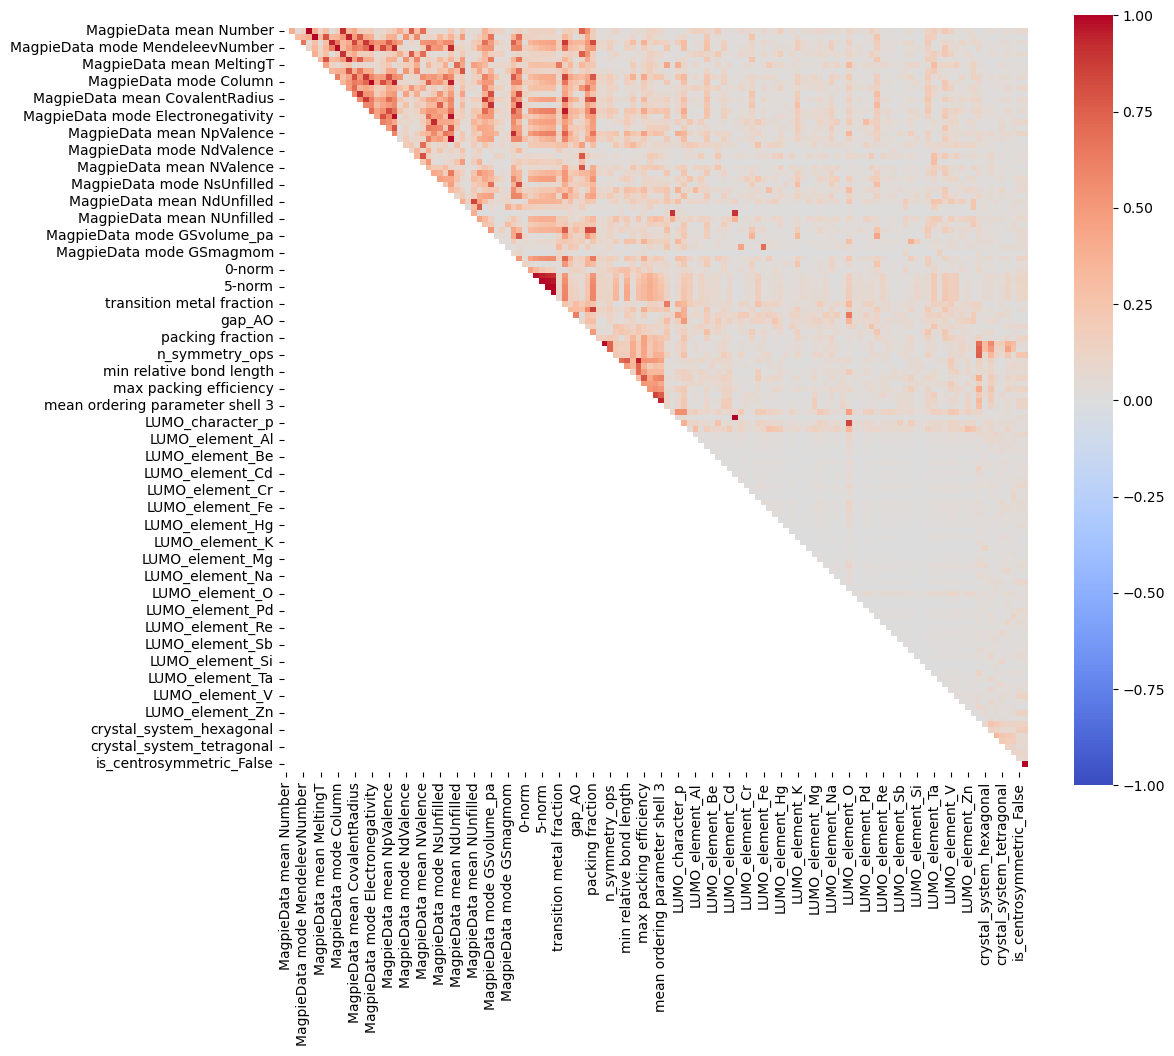

,Feature 1,Feature 2,Correlation
67,is_centrosymmetric_False,is_centrosymmetric_True,1.000000
65,LUMO_character_f,LUMO_element_Ce,1.000000
48,7-norm,10-norm,0.998943
1,MagpieData mode Number,MagpieData mode AtomicWeight,0.998778
0,MagpieData mean Number,MagpieData mean AtomicWeight,0.998556
...,...,...,...
18,MagpieData mode Electronegativity,MagpieData mode NsValence,0.809026
19,MagpieData mean Column,MagpieData mean NpValence,0.808189
17,MagpieData mode Column,MagpieData mode NsValence,0.808141
24,MagpieData mean NfValence,MagpieData mean NValence,0.807889


In [175]:
get_corr_mat(encoded_train_h_X, True, 0.8)

In [176]:
print(encoded_train_h_X.shape)

(1514, 131)


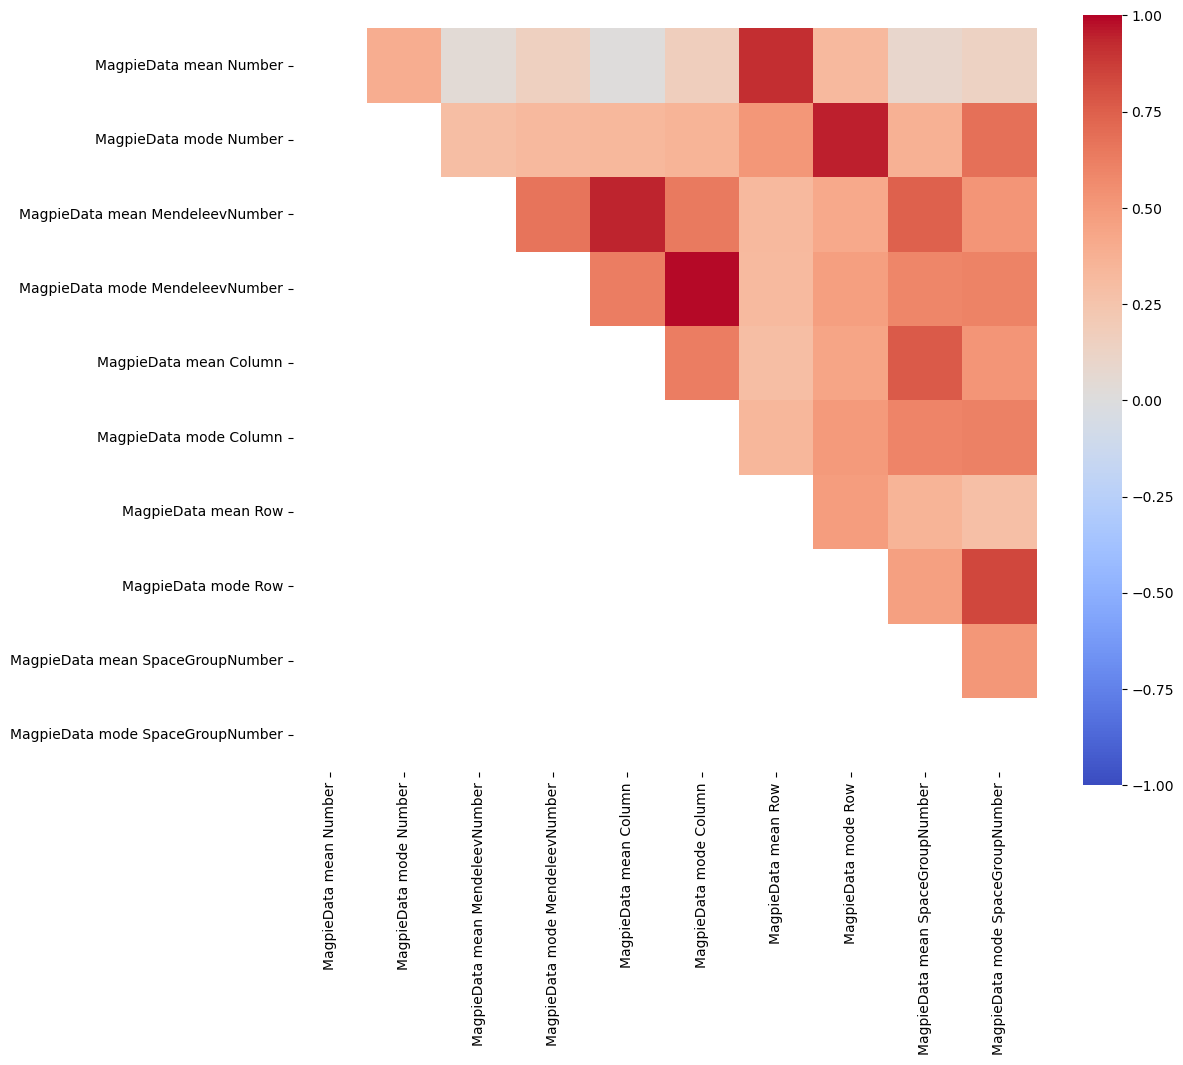

,Feature 1,Feature 2,Correlation
1,MagpieData mode MendeleevNumber,MagpieData mode Column,0.988144
3,MagpieData mode Number,MagpieData mode Row,0.948800
0,MagpieData mean MendeleevNumber,MagpieData mean Column,0.940340
2,MagpieData mean Number,MagpieData mean Row,0.918761
4,MagpieData mode Row,MagpieData mode SpaceGroupNumber,0.843198


In [177]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "Column" in c or "Row" in c or "Number" in c]], True, 0.8)

In [178]:
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "c" in c]).reset_index(drop=True)

In [179]:
# check for missing values
nan_cols = []
nan_rows = []

for row_index, row in train_h.iterrows():
    for col in row.index:
        if pd.isna(row[col]):
            if col not in nan_cols:
                nan_cols.append(col)
            if row_index not in nan_rows:
                nan_rows.append(row_index)
                
print("Columns with NaN values:", nan_cols)
print("Rows with NaN values:", len(nan_rows))

# get cleaned y values
train_h_clean = train_h.copy().drop(index=nan_rows).reset_index(drop=True)
train_h_y = train_h_clean['y_relaxed'].copy()
train_h_y.to_csv("data_clean/train_h_y.csv", index=False)
print(train_h_y.shape)

# get cleaned X values
encoded_train_h_X_clean = encoded_train_h_X.drop(index=nan_rows).reset_index(drop=True)
encoded_train_h_X_clean.to_csv("data_clean/train_h_X_v1.csv", index=False)
print(encoded_train_h_X_clean.shape)

Columns with NaN values: ['minimum local difference in Number', 'maximum local difference in Number', 'range local difference in Number', 'mean local difference in Number', 'avg_dev local difference in Number', 'minimum local difference in MendeleevNumber', 'maximum local difference in MendeleevNumber', 'range local difference in MendeleevNumber', 'mean local difference in MendeleevNumber', 'avg_dev local difference in MendeleevNumber', 'minimum local difference in AtomicWeight', 'maximum local difference in AtomicWeight', 'range local difference in AtomicWeight', 'mean local difference in AtomicWeight', 'avg_dev local difference in AtomicWeight', 'minimum local difference in MeltingT', 'maximum local difference in MeltingT', 'range local difference in MeltingT', 'mean local difference in MeltingT', 'avg_dev local difference in MeltingT', 'minimum local difference in Column', 'maximum local difference in Column', 'range local difference in Column', 'mean local difference in Column', 'a

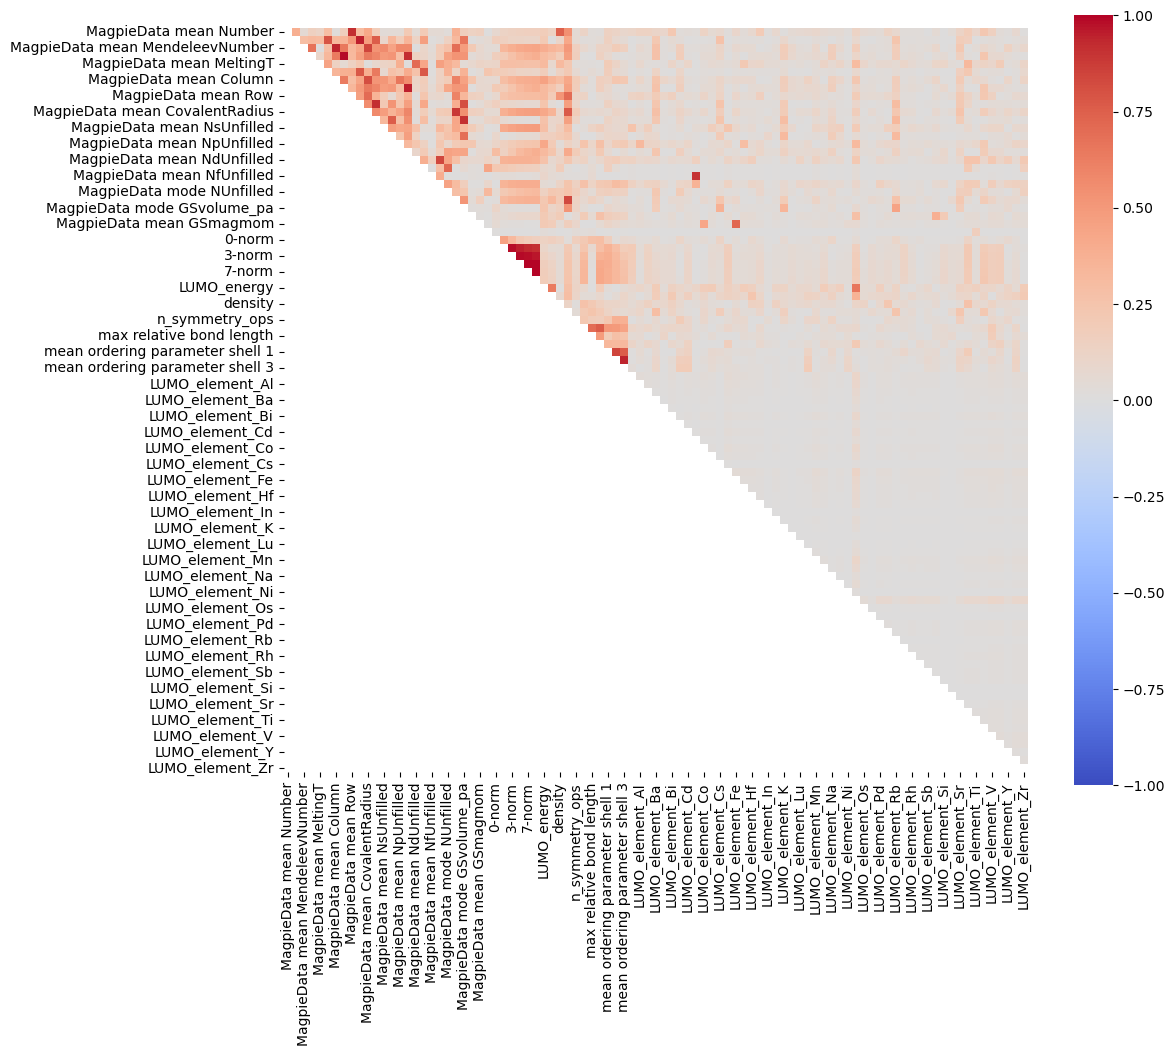

,Feature 1,Feature 2,Correlation
18,7-norm,10-norm,0.998933
14,5-norm,7-norm,0.997965
17,5-norm,10-norm,0.994046
11,3-norm,5-norm,0.988515
1,MagpieData mode MendeleevNumber,MagpieData mode Column,0.988192
9,2-norm,3-norm,0.983883
13,3-norm,7-norm,0.977448
16,3-norm,10-norm,0.967741
3,MagpieData mode Number,MagpieData mode Row,0.946965
10,2-norm,5-norm,0.946852


In [180]:
get_corr_mat(encoded_train_h_X_clean, True, 0.85)